In [1]:
import sys
import os
current_dir = os.path.dirname(os.path.abspath('./'))
if not current_dir in sys.path:
    sys.path.append(current_dir)

import mneflow as mf
import mneflow
import tensorflow as tf
import numpy as np
from mneflow.models import BaseModel, LFCNN
from utils.machine_learning.designer import ModelDesign, ParallelDesign, LayerDesign
from utils.machine_learning.analyzer import ModelAnalyzer
from mneflow.layers import DeMixing, LFTConv, TempPooling, Dense
from mne.datasets import multimodal
import mne
from utils.machine_learning.confusion import ConfusionEstimator
from utils.machine_learning import one_hot_decoder
import sklearn.metrics as sm

from mne import channels, evoked, create_info

from scipy.signal import freqz, welch
from scipy.stats import spearmanr

2022-03-08 14:09:56.383764: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-08 14:09:56.383818: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
class LFRNN(BaseModel):
    def __init__(self, Dataset, specs=dict()):
        self.scope = 'lfcnn'
        specs.setdefault('filter_length', 7)
        specs.setdefault('n_latent', 32)
        specs.setdefault('pooling', 2)
        specs.setdefault('stride', 2)
        specs.setdefault('padding', 'SAME')
        specs.setdefault('pool_type', 'max')
        specs.setdefault('nonlin', tf.nn.relu)
        specs.setdefault('l1', 3e-4)
        specs.setdefault('l2', 0)
        specs.setdefault('l1_scope', ['fc', 'demix', 'lf_conv'])
        specs.setdefault('l2_scope', [])
        specs.setdefault('maxnorm_scope', [])
        
        super(LFRNN, self).__init__(Dataset, specs)

    def build_graph(self):
        
        self.design = ModelDesign(
            self.inputs,
            LayerDesign(tf.squeeze, axis=1),
            tf.keras.layers.Bidirectional(
                tf.keras.layers.LSTM(
                    self.specs['n_latent'],
                    bias_regularizer='l1',
                    return_sequences=True,
                    kernel_regularizer=tf.keras.regularizers.L1(.01),
                    recurrent_regularizer=tf.keras.regularizers.L1(.01),
                    dropout=0.4,
                    recurrent_dropout=0.4,
                ),
                merge_mode='sum'
            ),
            LayerDesign(tf.expand_dims, axis=1),
            LFTConv(
                size=self.specs['n_latent'],
                nonlin=self.specs['nonlin'],
                filter_length=self.specs['filter_length'],
                padding=self.specs['padding'],
                specs=self.specs
            ),
            TempPooling(
                pooling=self.specs['pooling'],
                pool_type=self.specs['pool_type'],
                stride=self.specs['stride'],
                padding=self.specs['padding'],
            ),
            tf.keras.layers.Dropout(self.specs['dropout'], noise_shape=None),
            Dense(size=self.out_dim, nonlin=tf.identity, specs=self.specs)
        )

        return self.design()
    
    def _get_spatial_covariance(self, dataset):
        n1_covs = []
        for x, y in dataset.take(5):
            n1cov = tf.tensordot(x[0,0], x[0,0], axes=[[0], [0]])
            n1_covs.append(n1cov)

        cov = tf.reduce_mean(tf.stack(n1_covs, axis=0), axis=0)

        return cov
    
    def get_component_relevances(self, X, y):
        model_weights = self.km.get_weights()
        base_loss, base_performance = self.km.evaluate(X, y, verbose=0)
        #if len(base_performance > 1):
        #    base_performance = bbase_performance[0]
        feature_relevances_loss = []
        n_out_t = self.out_weights.shape[0]
        n_out_y = self.out_weights.shape[-1]
        zeroweights = np.zeros((n_out_t,))
        for i in range(self.specs["n_latent"]):
            loss_per_class = []
            for jj in range(n_out_y):
                new_weights = self.out_weights.copy()
                new_bias = self.out_biases.copy()
                new_weights[:, i, jj] = zeroweights
                new_bias[jj] = 0
                new_weights = np.reshape(new_weights, self.out_w_flat.shape)
                model_weights[-2] = new_weights
                model_weights[-1] = new_bias
                self.km.set_weights(model_weights)
                loss = self.km.evaluate(X, y, verbose=0)[0]
                loss_per_class.append(base_loss - loss)
            feature_relevances_loss.append(np.array(loss_per_class))
            self.component_relevance_loss = np.array(feature_relevances_loss)
    
    
    def get_output_correlations(self, y_true):
        corr_to_output = []
        y_true = y_true.numpy()
        flat_feats = self.tc_out.reshape(self.tc_out.shape[0], -1)

        if self.dataset.h_params['target_type'] in ['float', 'signal']:
            for y_ in y_true.T:

                rfocs = np.array([spearmanr(y_, f)[0] for f in flat_feats.T])
                corr_to_output.append(rfocs.reshape(self.out_weights.shape[:-1]))

        elif self.dataset.h_params['target_type'] == 'int':
            y_true = y_true/np.linalg.norm(y_true, ord=1, axis=0)[None, :]
            flat_div = np.linalg.norm(flat_feats, 1, axis=0)[None, :]
            flat_feats = flat_feats/flat_div
            #print("ff:", flat_feats.shape)
            #print("y_true:", y_true.shape)
            for y_ in y_true.T:
                #print('y.T:', y_.shape)
                rfocs = 2. - np.sum(np.abs(flat_feats - y_[:, None]), 0)
                corr_to_output.append(rfocs.reshape(self.out_weights.shape[:-1]))

        corr_to_output = np.dstack(corr_to_output)

        if np.any(np.isnan(corr_to_output)):
            corr_to_output[np.isnan(corr_to_output)] = 0
        return corr_to_output
    
    
    def compute_patterns(self, data_path=None, output='patterns'):
        #vis_dict = None
        if not data_path: 
            print("Computing patterns: No path specified, using validation dataset (Default)")
            ds = self.dataset.val
        elif isinstance(data_path, str) or isinstance(data_path, (list, tuple)):
            ds = self.dataset._build_dataset(data_path, 
                                            split=False, 
                                            test_batch=None, 
                                            repeat=True)
        elif isinstance(data_path, mneflow.data.Dataset):
            if hasattr(data_path, 'test'):
                ds = data_path.test
            else:
                ds = data_path.val
        elif isinstance(data_path, tf.data.Dataset):
            ds = data_path
        else:
            raise AttributeError('Specify dataset or data path.')

        X, y = [row for row in ds.take(1)][0]

        self.fin_fc = self.design[-1]
        self.dmx_size = self.design[1].forward_layer.weights[1].shape[0]
        self.dmx = self.design[1]
        self.tconv = self.design[3]
        self.pool = self.design[4]
        
        self.out_w_flat = self.fin_fc.w.numpy()
        self.out_weights = np.reshape(self.out_w_flat, [-1, self.dmx_size,
                                            self.out_dim])
        self.out_biases = self.fin_fc.b.numpy()
        self.feature_relevances = self.get_component_relevances(X, y)
        
        #compute temporal convolution layer outputs for vis_dics
        tc_out = self.pool(self.tconv(self.dmx(X)).numpy())
        

        #compute data covariance
        X = X - tf.reduce_mean(X, axis=-2, keepdims=True)
        X = tf.transpose(X, [3, 0, 1, 2])
        X = tf.reshape(X, [X.shape[0], -1])
        self.dcov = tf.matmul(X, tf.transpose(X))

        # get spatial extraction fiter weights
        
        fw, fa, fb = (w.numpy() for w in self.design[1].forward_layer.weights)
        bw, ba, bb = (w.numpy() for w in self.design[1].backward_layer.weights)

        # fwd + bcwd
        # (kernel weights + kernel biases) * recurrent weights
        demx = (((fw + fb)@fa.T) + ((bw + bb)@ba.T))
        self.lat_tcs = np.dot(demx.T, X)
        del X

        if 'patterns' in output:
            self.patterns = np.dot(self.dcov, demx)

        else:
            self.patterns = demx

        kern = self.tconv.filters.numpy()
        self.filters = np.squeeze(kern)
        self.tc_out = np.squeeze(tc_out)
        self.corr_to_output = self.get_output_correlations(y)

In [23]:
def compute_patterns(self, data_path=None, output='patterns'):
    #vis_dict = None
    if not data_path: 
        print("Computing patterns: No path specified, using validation dataset (Default)")
        ds = self.dataset.val
    elif isinstance(data_path, str) or isinstance(data_path, (list, tuple)):
        ds = self.dataset._build_dataset(data_path, 
                                        split=False, 
                                        test_batch=None, 
                                        repeat=True)
    elif isinstance(data_path, mneflow.data.Dataset):
        if hasattr(data_path, 'test'):
            ds = data_path.test
        else:
            ds = data_path.val
    elif isinstance(data_path, tf.data.Dataset):
        ds = data_path
    else:
        raise AttributeError('Specify dataset or data path.')

    X, y = [row for row in ds.take(1)][0]

    self.fin_fc = self.design[-1]
    self.dmx_size = self.design[1].forward_layer.weights[1].shape[0]
    self.dmx = self.design[1]
    self.tconv = self.design[3]
    self.pool = self.design[4]
    
    self.out_w_flat = self.fin_fc.w.numpy()
    self.out_weights = np.reshape(self.out_w_flat, [-1, self.dmx_size,
                                        self.out_dim])
    self.out_biases = self.fin_fc.b.numpy()
    self.feature_relevances = self.get_component_relevances(X, y)
    
    #compute temporal convolution layer outputs for vis_dics
    # tc_out = self.pool(self.tconv(self.design[1](self.dmx(self.design[0](X)))).numpy())
    tc_out = ModelDesign(None, *model.design[:5])(X).numpy()

    #compute data covariance
    X = X - tf.reduce_mean(X, axis=-2, keepdims=True)
    X = tf.transpose(X, [3, 0, 1, 2])
    X = tf.reshape(X, [X.shape[0], -1])
    self.dcov = tf.matmul(X, tf.transpose(X))

    # get spatial extraction fiter weights
    
    fw, fa, fb = (w.numpy() for w in self.design[1].forward_layer.weights)
    bw, ba, bb = (w.numpy() for w in self.design[1].backward_layer.weights)

    # fwd + bcwd
    # (kernel weights + kernel biases) * recurrent weights
    demx = (((fw + fb)@fa.T) + ((bw + bb)@ba.T))
    self.lat_tcs = np.dot(demx.T, X)
    del X

    if 'patterns' in output:
        self.patterns = np.dot(self.dcov, demx)

    else:
        self.patterns = demx

    kern = self.tconv.filters.numpy()
    self.filters = np.squeeze(kern)
    self.tc_out = np.squeeze(tc_out)
    self.corr_to_output = self.get_output_correlations(y)

In [24]:
compute_patterns(model)

Computing patterns: No path specified, using validation dataset (Default)


In [28]:
from LFCNN_decoder import compute_temporal_parameters

nt = model.dataset.h_params['n_t']
time_courses = np.squeeze(model.lat_tcs.reshape([model.specs['n_latent'], -1, nt]))
times = (1/float(model.dataset.h_params['fs']))*np.arange(model.dataset.h_params['n_t'])
patterns = model.patterns.copy()
compute_patterns(model, meta['train_paths'], output='filters')
filters = model.patterns.copy()
franges, finputs, foutputs, fresponces = compute_temporal_parameters(model)

In [29]:
from collections import namedtuple

SpatialParameters = namedtuple('SpatialParameters', 'patterns filters')
TemporalParameters = namedtuple('TemporalParameters', 'franges finputs foutputs fresponces')
ComponentsOrder = namedtuple('ComponentsOrder', 'l2 compwise_loss weight output_corr weight_corr')
Predictions = namedtuple('Predictions', 'y_p y_true')
WaveForms = namedtuple('WaveForms', 'evoked induced times tcs')

import scipy as sp

induced = list()
for tc in time_courses:
    ls_induced = list()
    for lc in tc:
        widths = np.arange(1, 71)
        ls_induced.append(sp.signal.cwt(lc, sp.signal.ricker, widths))
    induced.append(np.array(ls_induced).mean(axis=0))
induced = np.array(induced)

wf = WaveForms(time_courses.mean(1), induced, times, time_courses)
spr = SpatialParameters(patterns, filters)
tp = TemporalParameters(franges, finputs, foutputs, fresponces)


In [34]:
epochs = epochs_list[0].copy()
epochs.load_data()
epochs.pick_types(meg='grad')
len(epochs.info['ch_names'])

204

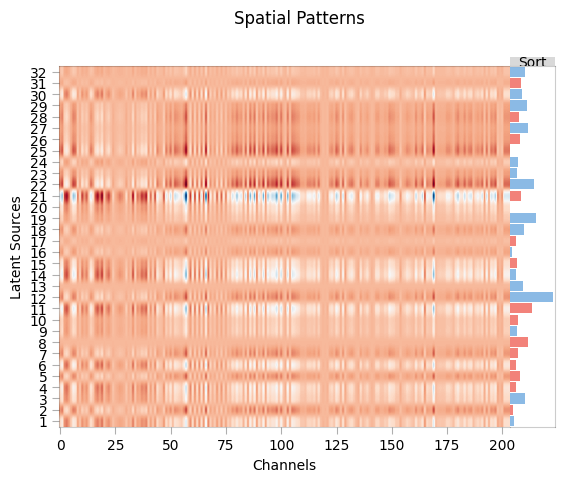

In [37]:
from lfcnn_vis import plot_spatial_weights

%matplotlib qt5

plot_spatial_weights(spr, tp, wf, epochs.info)

In [82]:
lfcnn_model.dmx.w.numpy().shape

(204, 32)

In [10]:
from utils.data_management import dict2str
# fw, fa, fb = (w.numpy() for w in model.design[1].forward_layer.weights)
# bw, ba, bb = (w.numpy() for w in model.design[1].backward_layer.weights)

# # fwd + bcwd
# # (kernel weights + kernel biases) * recurrent weights
# (((fw + fb)@fa.T) + ((bw + bb)@ba.T)).shape
# # for w in model.design[1].forward_layer.weights:
# #     print(w.shape)
# # print(dict2str(vars(model.design[1])))
s = np.random.rand(136, 1, 361, 204)
model.design[1](np.random.rand(136,361,204)).numpy().shape

(136, 361, 32)

In [20]:
ModelDesign(None, *model.design[:5])(np.random.rand(136, 1, 361, 204)).numpy().shape

(136, 1, 73, 32)

In [6]:
model.compute_patterns()

Computing patterns: No path specified, using validation dataset (Default)


ValueError: Input 0 of layer "bidirectional" is incompatible with the layer: expected ndim=3, found ndim=4. Full shape received: (136, 1, 361, 204)

In [3]:
mne.set_log_level(verbose='CRITICAL')
fname_raw = os.path.join(multimodal.data_path(), 'multimodal_raw.fif')
raw = mne.io.read_raw_fif(fname_raw)
cond = raw.acqparser.get_condition(raw, None)
condition_names = [k for c in cond for k,v in c['event_id'].items()]
epochs_list = [mne.Epochs(raw, **c) for c in cond]
epochs = mne.concatenate_epochs(epochs_list)
epochs = epochs.pick_types(meg='grad')
X = np.array([])
Y = list()
for i, epochs in enumerate(epochs_list):
    data = epochs.get_data()
    if i == 0:
        X = data.copy()
    else:
        X = np.append(X, data, axis=0)
    Y += [i for _ in range(data.shape[0])]

Y = np.array(Y)
X = np.array([X[i, epochs._channel_type_idx['grad'], :] for i, _ in enumerate(X)])
original_X = X.copy()
original_Y = Y.copy()

import_opt = dict(savepath='../tfr/',
                  out_name='mne_sample_epochs',
                  fs=600,
                  input_type='trials',
                  target_type='int',
                  picks={'meg':'grad'},
                  scale=True,  # apply baseline_scaling
                  crop_baseline=True,  # remove baseline interval after scaling
                  decimate=None,
                  scale_interval=(0, 60),  # indices in time axis corresponding to baseline interval
                #   n_folds=5,  # validation set size set to 20% of all data
                  n_folds=5,
                  overwrite=True,
                  segment=False,
                  test_set='holdout'
)
lf_params = dict(n_latent=32, #number of latent factors
                  filter_length=17, #convolutional filter length in time samples
                  nonlin = tf.nn.relu,
                  padding = 'SAME',
                  pooling = 5,#pooling factor
                  stride = 5, #stride parameter for pooling layer
                  pool_type='max',
                  model_path = import_opt['savepath'],
                  dropout = .5,
                  l1_scope = ["weights"],
                  l1=3e-3)


In [4]:
meta = mf.produce_tfrecords((X, Y), **import_opt)  
dataset = mf.Dataset(meta, train_batch=100)

importing from tuple
input shapes: X- (940, 204, 361) targets- (940, 1)
Preprocessing:
Scaling to interval 0.0 - 60.0
Splitting sets
Preprocessed: (940, 1, 361, 204) (940, 8) folds: 6 x 156
936
Prepocessed sample shape: (1, 361, 204)
Target shape actual/metadata:  (8,) (8,)
Saving TFRecord# 0


2022-03-08 14:10:43.653883: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-08 14:10:43.653918: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-08 14:10:43.653935: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (arcolinux-machine): /proc/driver/nvidia/version does not exist
2022-03-08 14:10:43.654188: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [70]:
lfcnn_model = mf.models.LFCNN(dataset, lf_params)
lfcnn_model.build()
lfcnn_model.train(n_epochs=25, eval_step=100, early_stopping=5)

Setting reg for dmx, to l1
Built: dmx input: (None, 1, 361, 204)
Setting reg for tconv, to l1
Built: tconv input: (None, 1, 361, 32)
Setting reg for fc, to l1
Built: fc input: (None, 1, 73, 32)
Input shape: (1, 361, 204)
y_pred: (None, 8)
Initialization complete!
Epoch 1/25
100/100 - 4s - loss: 5.3373 - cat_ACC: 0.1744 - val_loss: 4.9751 - val_cat_ACC: 0.1791 - 4s/epoch - 36ms/step
Epoch 2/25
100/100 - 3s - loss: 4.6002 - cat_ACC: 0.3489 - val_loss: 4.4564 - val_cat_ACC: 0.3433 - 3s/epoch - 30ms/step
Epoch 3/25
100/100 - 3s - loss: 3.9821 - cat_ACC: 0.5316 - val_loss: 3.9540 - val_cat_ACC: 0.4851 - 3s/epoch - 30ms/step
Epoch 4/25
100/100 - 3s - loss: 3.4364 - cat_ACC: 0.6907 - val_loss: 3.5016 - val_cat_ACC: 0.6194 - 3s/epoch - 31ms/step
Epoch 5/25
100/100 - 3s - loss: 2.9696 - cat_ACC: 0.8054 - val_loss: 3.1273 - val_cat_ACC: 0.7015 - 3s/epoch - 31ms/step
Epoch 6/25
100/100 - 3s - loss: 2.6139 - cat_ACC: 0.8724 - val_loss: 2.8255 - val_cat_ACC: 0.7239 - 3s/epoch - 31ms/step
Epoch 7/25

In [48]:
y_true_test, y_pred_test = model.predict(meta['test_paths'])

y_t = one_hot_decoder(y_true_test)
y_p = one_hot_decoder(y_pred_test)

# tn, fp, fn, tp = sm.confusion_matrix(y_t, y_p).ravel()

print(sm.accuracy_score(y_t, y_p))

# ce = ConfusionEstimator(tp, tn, fp, fn)

# print(
#     f'\tT\tF\n'\
#     f'P\t{tp}\t{fp}\n'\
#     f'N\t{tn}\t{fn}\n'
#     f'Accuracy: {ce.acc}\n'\
#     f'Specificity: {ce.spec}\n'\
#     f'Sensitivity: {ce.sens}\n'
# )

0.8846153846153846


In [5]:
model = LFRNN(dataset, lf_params)
model.build()
model.train(n_epochs=5, eval_step=100, early_stopping=5)

Setting reg for fc, to l1
Setting reg for tconv, to l1
Built: tconv input: (None, 1, 361, 32)
Built: fc input: (None, 1, 73, 32)
Input shape: (1, 361, 204)
y_pred: (None, 8)
Initialization complete!
Epoch 1/5
100/100 - 44s - loss: 37.0731 - cat_ACC: 0.1391 - val_loss: 29.3185 - val_cat_ACC: 0.1250 - 44s/epoch - 444ms/step
Epoch 2/5
100/100 - 40s - loss: 22.9942 - cat_ACC: 0.2224 - val_loss: 17.2225 - val_cat_ACC: 0.2647 - 40s/epoch - 396ms/step
Epoch 3/5
100/100 - 40s - loss: 12.7790 - cat_ACC: 0.4019 - val_loss: 8.9712 - val_cat_ACC: 0.4926 - 40s/epoch - 397ms/step
Epoch 4/5
100/100 - 40s - loss: 6.3802 - cat_ACC: 0.5917 - val_loss: 4.5278 - val_cat_ACC: 0.6103 - 40s/epoch - 402ms/step
Epoch 5/5
100/100 - 36s - loss: 3.5480 - cat_ACC: 0.7264 - val_loss: 3.2196 - val_cat_ACC: 0.6691 - 36s/epoch - 362ms/step
1/1 [==============================] - 0s 244ms/step - loss: 3.2196 - cat_ACC: 0.6691
Training complete: loss: 3.219550132751465, Metric: 0.6691176295280457
1/1 [===================

In [46]:
y_true_test, y_pred_test = model.predict(meta['test_paths'])

y_t = one_hot_decoder(y_true_test)
y_p = one_hot_decoder(y_pred_test)

print(sm.accuracy_score(y_t, y_p))

0.7884615384615384
